In [ ]:
# %pip install pyqtgraph
# %pip install PyQt5
# %pip install PySide2 
# %pip install scikit-learn
%pip install seaborn
%pip install vtk
# %pip install apptools
# %pip install envisage
# %pip install pyface
# %pip install traits
%pip install traitsui
%pip install mayavi
%pip install pandas

In [2]:
import PyQt5
import PySide2
import traitsui
import vtk
import mayavi
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mayavi import mlab
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.spatial import Delaunay
import seaborn as sns
print('traitsui version:', traitsui.__version__)
print('PySide2 version:', PySide2.__version__)

print("VTK version:", vtk.vtkVersion.GetVTKVersion())
print("Mayavi version:", mayavi.__version__)

traitsui version: 8.0.0
PySide2 version: 5.15.2.1
VTK version: 9.2.6
Mayavi version: 4.8.1


In [7]:
# загрузка датасета вин

# Load the dataset
df = pd.read_csv('winequality-red.csv',sep=';')
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [8]:
# оригинальные колонки датасета
origcols=list(df.columns)
origcols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

# статистика по значениям качества:

In [9]:
# сколько каких оценок вина встречается
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [10]:
# оценка количества хороших вин(>6.5) и не относящихся к хорошим
df['column_bin'] = pd.cut(df['quality'], bins=[0, 6.5, 8], include_lowest=True,right=True)
bin_counts = df['column_bin'].value_counts()
print(bin_counts)


column_bin
(-0.001, 6.5]    1382
(6.5, 8.0]        217
Name: count, dtype: int64


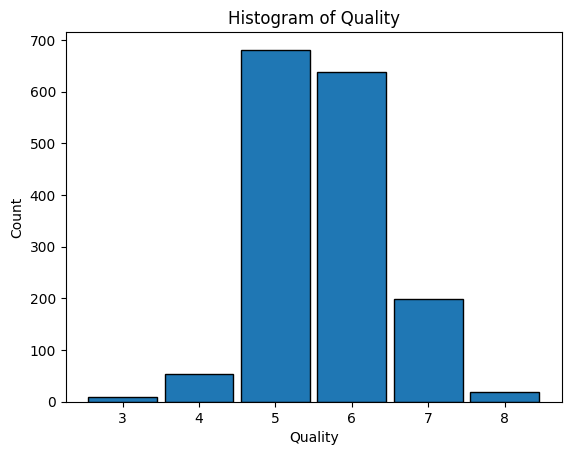

In [11]:
# гистограмма количеств каждой оценки
# Calculate counts of each unique 'quality' value
counts = df['quality'].value_counts().sort_index()

# Calculate bin centers (which are just the unique 'quality' values)
bin_centers = counts.index

# Create new figure
plt.figure()

# Use bar to plot histogram with centered bars
plt.bar(bin_centers, counts, width=0.9, align='center', edgecolor='black', tick_label=bin_centers)

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Histogram of Quality')

# Show the plot
plt.show()

In [12]:
# кодирование целевой переменной
# Split the data into features and target variable
X = df[origcols].drop('quality', axis=1)
y = df['quality']

# Convert the target variable into a categorical variable
y = y.apply(lambda x: 'good wine' if x > 6.5 else 'bad wine')

# Encode the target variable 1-хорошие вина, 0 - остальные
le = LabelEncoder()
y_le = le.fit_transform(y)


In [13]:
# повтор-проверка результата (bin_counts) 1382/217
dff = pd.DataFrame(y_le, columns=['ColumnName'])
dff['ColumnName'].value_counts()

ColumnName
0    1382
1     217
Name: count, dtype: int64

In [14]:
# разбиение на тестовую и тренировочную части, подбор гиперпараметров по сетке

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#применить так же стандартизацию к полному ряду для визуализации
X_t = scaler.transform(X)


from sklearn.metrics import make_scorer, accuracy_score
from time import time
# Define the SVM model
svm = SVC()


In [13]:
svm = SVC(class_weight={0: 1382, 1: 217})
# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': [ 'rbf']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,verbose=4,n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(class_weight={0: 1382, 1: 217}), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['rbf']},
             verbose=4)

In [14]:
# это тестовая часть - оказалась нецелесообразна - можно пропустить
# попытка организовать индикатор прогресса, оказалось, вызов колбэк происходит только при n_jobs=1, это очень долгий расчет..
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from itertools import product
import time

class TimedSVC(BaseEstimator, ClassifierMixin):
    callback = None
    def __init__(self, *args, **kwargs):
        if 'callback' in kwargs:
            TimedSVC.callback = kwargs.pop('callback')
        self.svc = SVC(*args, **kwargs)

    def fit(self, X, y):
        X, y = check_X_y(X, y)        
        start = time.time()
        
        self.svc.fit(X, y)
        elapsed_time = time.time()-start
        #Editing to call the callback with parameters and elapsed time
        if self.callback: 
            TimedSVC.callback(self.svc.get_params(), elapsed_time)
        
        # for the check_is_fitted in the predict method
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self)
        return self.svc.predict(X)
    
    def get_params(self, deep=True):
        return self.svc.get_params(deep)
    
    def set_params(self, **params):
        self.svc.set_params(**params)
        super().set_params(**params)
        return self

def create_callback(total_combinations):
    times_of_combinations = {} # storing time of each fit per combination
    avg_time_per_fit = [0]
    def print_params_time(params, elapsed_time):
        frozen_params = frozenset(params.items())
        if frozen_params in times_of_combinations:
            times_of_combinations[frozen_params].append(elapsed_time)
        else:
            times_of_combinations[frozen_params] = [elapsed_time]
        total_times = [sum(times) for times in times_of_combinations.values()]
        avg_time_per_fit[0] = sum(total_times) / len(total_times)
        remaining_combinations = total_combinations - len(times_of_combinations)
        estimated_remaining_time = max(avg_time_per_fit[0] * remaining_combinations, 0)
        print("Fit done, params: ", params)
        print("Time elapsed for current fit: ", elapsed_time, "s")
        print(f"{len(times_of_combinations)} unique combinations completed. Average time per combination: {avg_time_per_fit[0]} s")
        print(f"{remaining_combinations} combinations remaining. Estimated remaining time: {estimated_remaining_time} s")
    return print_params_time

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] #
}

combination_counts = len(list(product(*param_grid.values())))

# Creating the callback with total combination counts
print_params_time = create_callback(combination_counts)

# Pass the callback
svm = TimedSVC(callback=print_params_time)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,  n_jobs=-1)
grid_search.fit(X_train, y_train)

Fit done, params:  {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Time elapsed for current fit:  0.0830070972442627 s
1 unique combinations completed. Average time per combination: 0.0830070972442627 s
63 combinations remaining. Estimated remaining time: 5.22944712638855 s


GridSearchCV(cv=5,
             estimator=TimedSVC(C=1.0, break_ties=False, cache_size=200,
                                class_weight=None, coef0=0.0,
                                decision_function_shape='ovr', degree=3,
                                gamma='scale', kernel='rbf', max_iter=-1,
                                probability=False, random_state=None,
                                shrinking=True, tol=0.001, verbose=False),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [14]:
# вывод оптимальных найденных параметров
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using the accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Optionally, you can also print the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Best hyperparameters: {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Accuracy: 0.8875
Confusion Matrix:
[[273   0]
 [ 36  11]]


можно сделать вывод, что модель хорошо справляется с предсказанием  класса плохих вин (большинства примеров), но менее точна в предсказании хорошиъ. Это может быть связано с несбалансированностью классов в данных

In [11]:

# Define the hyperparameters to tune
param_grid = {
    'C': [0.5,0.7, 1, 2],
    'gamma': [0.05,0.1, 1, 2],
    'kernel': ['rbf']
}
# подбор дал те же результаты:
# Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
# Accuracy: 0.890625
# Confusion Matrix:
# [[271   2]
#  [ 33  14]]

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.5, 0.7, 1, 2], 'gamma': [0.05, 0.1, 1, 2],
                         'kernel': ['rbf']},
             verbose=4)

In [15]:
# сведение количества признаков к 3-м для 3д визуализации пространства классов и их разделения поверхностью функции принятия решения

# оптимальные гиперпараметры, подобранные на сетке
C=1
gamma=1
clf = SVC(C=C, gamma=gamma)
pca = PCA(n_components=3)
# уменьшение размерности
X_pca = pca.fit_transform(X_t)
clf = SVC(C=C, gamma=gamma)
clf.fit(X_pca, y_le)

# разделение классов для удобства отрисовки
class_0_indices = y_le == 0
class_1_indices = y_le == 1

X_pca_class_0 = X_pca[class_0_indices]
X_pca_class_1 = X_pca[class_1_indices]


num=150 #густота сетки
x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=num)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=num)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=num)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

# функция принятия решения
Z_dec_func = clf.decision_function(xyz).reshape(X.shape)


In [16]:
# класс для сохранения/восстановления состояния расчета
# все,что выше, можно не выполнять, если есть сохраненный расчет
class ModelData:
    def __init__(self, clf, pca, X_pca, X_pca_class_0, X_pca_class_1,Z_dec_func,num):
        self.clf = clf
        self.pca = pca
        self.X_pca = X_pca
        self.X_pca_class_0 = X_pca_class_0
        self.X_pca_class_1 = X_pca_class_1
        self.Z_dec_func=Z_dec_func
        self.num=num


In [15]:
# Сохранение данных
data = ModelData(clf, pca, X_pca, X_pca_class_0, X_pca_class_1,Z_dec_func,num)
with open('model_data.pkl', 'wb') as f:
    pickle.dump(data, f)        

In [4]:
# быстрое восстановление предыдущего расчета для многочисленных проб, когда питон приходится рестартовать из-за крушения маяви
with open('model_data.pkl', 'rb') as f:
    data = pickle.load(f)

clf = data.clf
pca = data.pca
X_pca = data.X_pca
X_pca_class_0 = data.X_pca_class_0
X_pca_class_1 = data.X_pca_class_1
Z_dec_func=data.Z_dec_func
num=data.num
#повтор блока , чтобы не хранить это, так проще
x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=num)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=num)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=num)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T


In [17]:
from mayavi import mlab
import numpy as np
from scipy.spatial import Delaunay

n_colors = 22
colors = sns.color_palette(n_colors=n_colors)


mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))

# Visualize the points of class 0 in red
mlab.points3d(X_pca_class_0[:, 0], X_pca_class_0[:, 1], X_pca_class_0[:, 2], color=(1, 0, 0), scale_factor=0.2)

# Visualize the points of class 1 in blue
mlab.points3d(X_pca_class_1[:, 0], X_pca_class_1[:, 1], X_pca_class_1[:, 2], color=(0, 0, 1), scale_factor=0.2)

mask = np.abs(Z_dec_func) < 0.1

dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]
threshold = np.sqrt(dx**2 + dy**2 + dz**2)

pts = mlab.pipeline.scalar_scatter(X[mask], Y[mask], Z[mask])
# Создание треугольной сетки
tri = Delaunay(pts.mlab_source.points)

# Определение индексов треугольников, удовлетворяющих условию
valid_triangles = []
for simplex in tri.simplices:
    p1, p2, p3 = pts.mlab_source.points[simplex[:3]]  # Извлекаем только первые три индекса
    side1 = np.linalg.norm(p2 - p1)
    side2 = np.linalg.norm(p3 - p2)
    side3 = np.linalg.norm(p1 - p3)
    if side1 <= threshold and side2 <= threshold and side3 <= threshold:
        valid_triangles.append(simplex[:3])

# Визуализация поверхности
mlab.triangular_mesh(pts.mlab_source.points[:, 0], pts.mlab_source.points[:, 1], pts.mlab_source.points[:, 2], valid_triangles, color=(0, 1, 0), opacity=0.5)

mlab.show()


изначально параметров много, но для визуализации их количество сведено к трем с помощью pca.
зеленые поверхности показывают границу между двумя классами, где функция принятия решения Z_dec_func близка к 0, т.о. rbf дает совсем нелинейную границу, что позволяет разделять между собой классы со сложными отношениями (синие точки это хорошее вино)

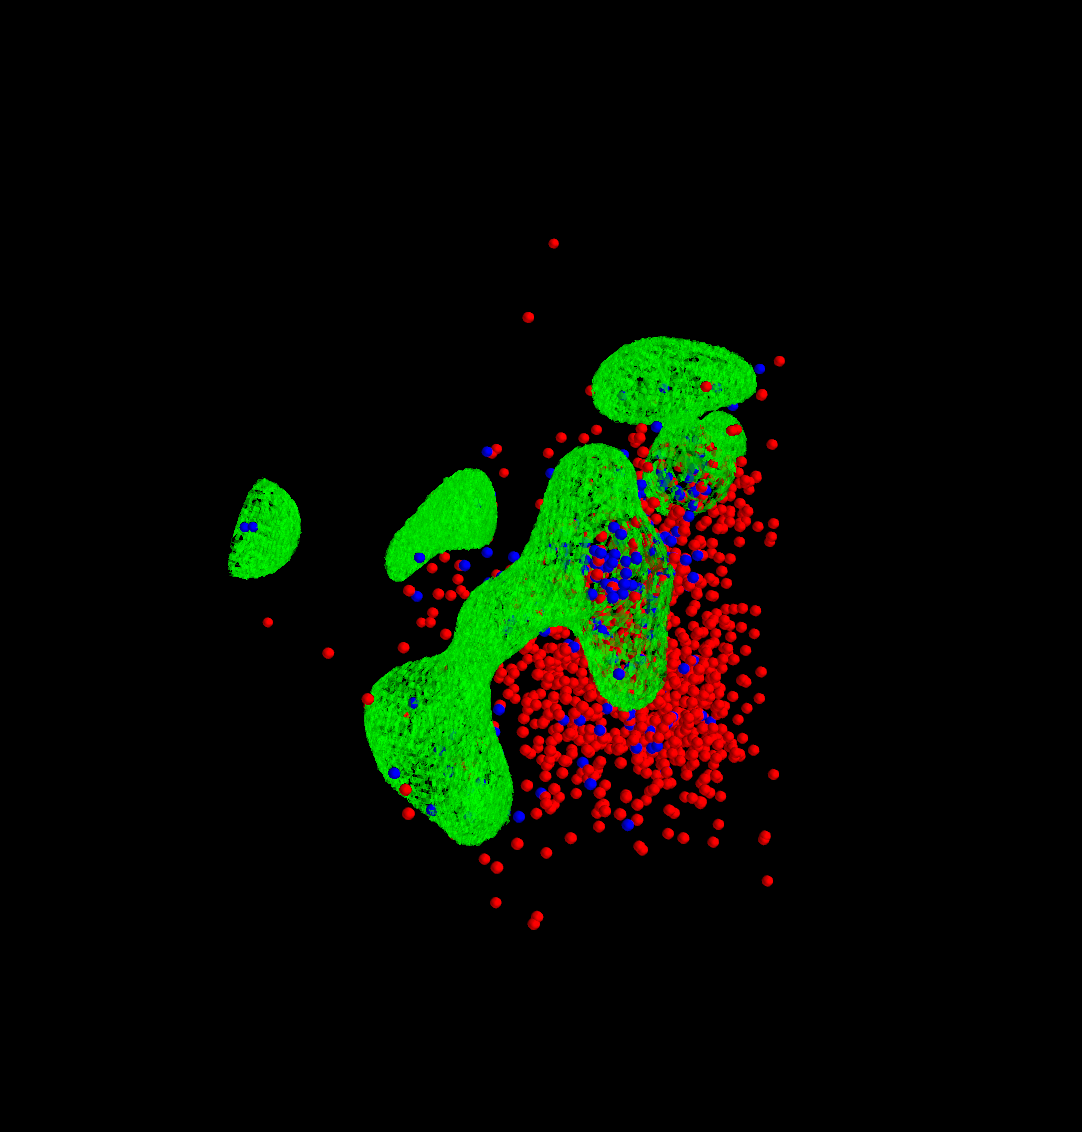

In [18]:
# отдельный блок - обучение модели с уменьшенным пространством признаков для сравнения поверхностей деления классов
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Уменьшение размерности с использованием PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

# Определение параметров для поиска
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['rbf']
}

# Создание SVM-классификатора
svm = SVC(class_weight={0: 1382, 1: 217})

# Выполнение GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1)
grid_search.fit(X_pca, y_train)

# Вывод оптимальных найденных параметров
print("Best hyperparameters:", grid_search.best_params_)

# Обучение модели с лучшими гиперпараметрами на уменьшенных данных
best_model = grid_search.best_estimator_
best_model.fit(X_pca, y_train)

# Преобразование тестовых данных с использованием PCA
X_test_pca = pca.transform(X_test)

# Предсказание меток для тестовых данных
y_pred = best_model.predict(X_test_pca)

# Оценка модели с использованием метрики точности (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Опционально, вы можете также вывести матрицу ошибок (confusion matrix)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}
Accuracy: 0.8875
Confusion Matrix:
[[273   0]
 [ 36  11]]


Confusion Matrix: не изменилась для модели с уменьшенным до 3х количеством признаков не отличаются от модели с полным первоначальным набором признаков,
точность несколько уменьшилась

In [19]:
C=0.1
gamma=100
clf = SVC(C=C, gamma=gamma)
X_pca = pca.fit_transform(X_t)
clf.fit(X_pca, y_le) #X_pca сформировано раньше

num=150 #густота сетки
x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=num)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=num)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=num)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
# функция принятия решения
Z_dec_func = clf.decision_function(xyz).reshape(X.shape)


In [ ]:

mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))

# Visualize the points of class 0 in red
mlab.points3d(X_pca_class_0[:, 0], X_pca_class_0[:, 1], X_pca_class_0[:, 2], color=(1, 0, 0), scale_factor=0.2)

# Visualize the points of class 1 in blue
mlab.points3d(X_pca_class_1[:, 0], X_pca_class_1[:, 1], X_pca_class_1[:, 2], color=(0, 0, 1), scale_factor=0.2)

mask = np.abs(Z_dec_func) < 0.1

dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]
threshold = np.sqrt(dx**2 + dy**2 + dz**2)

pts = mlab.pipeline.scalar_scatter(X[mask], Y[mask], Z[mask])
# Создание треугольной сетки
tri = Delaunay(pts.mlab_source.points)

# Определение индексов треугольников, удовлетворяющих условию
valid_triangles = []
for simplex in tri.simplices:
    p1, p2, p3 = pts.mlab_source.points[simplex[:3]]  # Извлекаем только первые три индекса
    side1 = np.linalg.norm(p2 - p1)
    side2 = np.linalg.norm(p3 - p2)
    side3 = np.linalg.norm(p1 - p3)
    if side1 <= threshold and side2 <= threshold and side3 <= threshold:
        valid_triangles.append(simplex[:3])

# Визуализация поверхности
mlab.triangular_mesh(pts.mlab_source.points[:, 0], pts.mlab_source.points[:, 1], pts.mlab_source.points[:, 2], valid_triangles, color=(0, 1, 0), opacity=0.5)

mlab.show()

In [22]:
# pts.mlab_source.points
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
# Создание новых признаков
df['FreePlusTotalSulfurDioxide'] = df['free sulfur dioxide'] + df['total sulfur dioxide']
df['SugarToAcidityRatio'] = df['residual sugar'] / (df['fixed acidity'] + df['volatile acidity'])
df['TotalAcidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
df['NearestIntegerQuality'] = df['quality'].round()
# Сумма свободного и общего диоксида серы (Free+SulfurDioxide): Возможно, общая концентрация диоксида серы (total sulfur dioxide) в сочетании со свободной концентрацией диоксида серы (free sulfur dioxide) может помочь определить качество вина. Вы можете создать новый признак, который будет являться суммой значений этих двух признаков.

# Отношение сахара и кислотности (Sugar:Acidity Ratio): Отношение между содержанием сахара (residual sugar) и кислотности вина может отражать баланс между сладостью и кислотностью, что, в свою очередь, может влиять на качество вина. Вы можете создать новый признак, который будет представлять собой отношение сахара к общей кислотности (сумма fixed acidity и volatile acidity).

# Сумма кислот (Total Acidity): Вы можете объединить значения fixed acidity, volatile acidity и citric acid, чтобы получить показатель общей кислотности вина.

# Номер ближайшей целочисленной оценки (Nearest Integer Quality): Поскольку качество вина обозначается целочисленной оценкой от 0 до 10, вы можете создать новый признак, который будет содержать ближайшую качественную целочисленную оценку для каждого вина. Это может помочь модели лучше улавливать различия в качестве.

In [20]:
pts.mlab_source.points[[8548, 8549, 8546, 8584],:]

array([[0.88637629, 5.15014348, 5.67219268],
       [0.88637629, 5.15014348, 5.77030464],
       [0.74907522, 5.15014348, 5.96652856],
       [1.02367735, 5.25275725, 5.77030464]])

In [19]:
pts.mlab_source.points[[8548, 8549, 8546, 8584],:][[0,1],0]

array([0.88637629, 0.88637629])

In [14]:
pts.mlab_source.points

array([[-2.13424721, -3.46941313,  1.06093058],
       [-2.13424721, -3.46941313,  1.15904253],
       [-2.13424721, -3.46941313,  1.25715449],
       ...,
       [ 1.57288163,  5.25275725,  5.8684166 ],
       [ 1.57288163,  5.25275725,  5.96652856],
       [ 1.57288163,  5.25275725,  6.06464052]])

In [13]:
tri.simplices

array([[8548, 8549, 8546, 8584],
       [3512, 3795, 6897, 7089],
       [2971, 2720, 2970, 3252],
       ...,
       [4130, 3870, 3875, 3871],
       [4130, 4553, 4134, 4362],
       [4130, 3876, 4553, 4134]], dtype=int32)

In [22]:
import numpy as np
from mayavi import mlab
vertices = np.array([[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
faces = np.array([[0, 1, 0, 0],[1, 2, 1, 2],[2, 3, 3, 3]])
mlab.triangular_mesh(vertices[0,:], vertices[1,:], vertices[2,:], faces.T)
mlab.show()

In [17]:
import seaborn as sns
n_colors = 22
colors = sns.color_palette(n_colors=n_colors)

mlab.figure(bgcolor=(0, 0, 0),size=(800,800)) #(1, 1, 1)
# Visualize the points of class 0 in red
mlab.points3d(X_pca_class_0[:, 0], X_pca_class_0[:, 1], X_pca_class_0[:, 2], color=(1, 0, 0), scale_factor=0.2)

# Visualize the points of class 1 in blue
mlab.points3d(X_pca_class_1[:, 0], X_pca_class_1[:, 1], X_pca_class_1[:, 2], color=(0, 0, 1), scale_factor=0.2)
# mlab.points3d(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 2*y_le-1, colormap='RdBu', scale_factor=0.3)
# mlab.points3d(X.ravel(), Y.ravel(), Z.ravel(), -Z_dec_func.ravel(), colormap='RdBu', scale_factor=0.1, opacity=0.3)
# mlab.points3d(X.ravel(), Y.ravel(), Z.ravel(), -Z_dec_func.ravel(), colormap='RdBu', scale_factor=0.1, opacity=0.3)
# Создайте маску, чтобы выбрать только точки близкие к 0
mask = np.abs(Z_dec_func) < 0.1

# Визуализируйте только точки близкие к 0 с помощью маски
# mlab.points3d(X[mask], Y[mask], Z[mask],  color=(0, 1,0 ), scale_factor=0.02, opacity=0.3)

# Create the points without visualizing them
pts = mlab.pipeline.scalar_scatter(X[mask], Y[mask], Z[mask])
# # Create and visualize the mesh
# mesh = mlab.pipeline.delaunay2d(pts)
# surf = mlab.pipeline.surface(mesh, color=(0, 1, 0), opacity=0.5)
# Set the threshold distance
threshold = 0.4

# Get the coordinates of the points
points = np.array(pts.mlab_source.dataset.points)

# Initialize the list to store the groups of points
groups = []

# Iterate over each point in the array
for F in points:
    # Flag to check if F is added to any group
    added_to_group = False
    
    # Iterate over each existing group
    for group in groups:
        # Check if there exists at least one point in the group that is within the threshold distance from F
        if any(np.linalg.norm(F - point) <= threshold for point in group):
            # Add F to the group
            group.add(tuple(F))
            added_to_group = True
            break
    
    # If F was not added to any existing group, create a new group with F as the only point
    if not added_to_group:
        new_group = {tuple(F)}
        groups.append(new_group)

# Prinint(f"Group {i+1}: {group}")
# Visualize the separate surfaces for each group of points
for i, group in enumerate(groups):
    # Convert the group of points to a numpy array
    group_points = np.array(list(group))
    if i<6:print(f'{i:10}',end='\r')

    # Create the points without visualizing them
    pts = mlab.pipeline.scalar_scatter(group_points[:,0], group_points[:,1], group_points[:,2])
    # Create and visualize the mesh
    mesh = mlab.pipeline.delaunay2d(pts)
    surf = mlab.pipeline.surface(mesh, color=colors[i], opacity=0.5) #(0, 1, 0)
print(f'goups {len(groups):10}',end='\n\r')


# Display the Mayavi scene
mlab.show()

goups          6


In [49]:
decf = pd.DataFrame({'Z_dec_func': -Z_dec_func.ravel()})
decf['bin'] = pd.cut(decf['Z_dec_func'], bins=[-1, -0.5, 0,0.5, 1], include_lowest=True, right=True)

# Подсчет количества точек в каждом диапазоне
bin_counts = decf['bin'].value_counts()

# Вывод результатов
print(bin_counts)

bin
(0.5, 1.0]        23206
(0.0, 0.5]          912
(-0.5, 0.0]         345
(-1.001, -0.5]      137
Name: count, dtype: int64


In [59]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
from mayavi import mlab

C = 1
gamma = 1
clf = SVC(C=C, gamma=gamma)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_t)
clf = SVC(C=C, gamma=gamma)
clf.fit(X_pca, y_le)

x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=100)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=100)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=100)
X, Y, Z = np.meshgrid(x, y, z)

xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
Z_dec_func = clf.decision_function(xyz).reshape(X.shape)

mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))

# Split the data into two classes
class_0_indices = y_le == 0
class_1_indices = y_le == 1

X_pca_class_0 = X_pca[class_0_indices]
X_pca_class_1 = X_pca[class_1_indices]

# Visualize the points of class 0 in red
mlab.points3d(X_pca_class_0[:, 0], X_pca_class_0[:, 1], X_pca_class_0[:, 2], color=(1, 0, 0), scale_factor=0.2)

# Visualize the points of class 1 in blue
mlab.points3d(X_pca_class_1[:, 0], X_pca_class_1[:, 1], X_pca_class_1[:, 2], color=(0, 0, 1), scale_factor=0.2)

# Create the points without visualizing them
pts = mlab.pipeline.scalar_scatter(X.ravel(), Y.ravel(), Z.ravel(), Z_dec_func.ravel())

# Create and visualize the mesh
mesh = mlab.pipeline.delaunay2d(pts)
surf = mlab.pipeline.surface(mesh)
surf.actor.property.opacity = 0.5
surf.actor.property.color = (0.5, 0.5, 0.5)

# Create a mask to select only points close to 0
mask = np.abs(Z_dec_func) < 0.1

# Visualize only points close to 0 using the mask
mlab.points3d(X[mask], Y[mask], Z[mask], color=(0, 1, 0), scale_factor=0.1)

mlab.show()

In [ ]:
Z_dec_func.shape

In [ ]:
dff = pd.DataFrame(Z_dec_func)
print(dff[0].value_counts())

In [63]:
print(X_pca.shape,np.array(y_le).shape)

(1599, 3) (1599,)
